## Exercise 1: Image derivatives

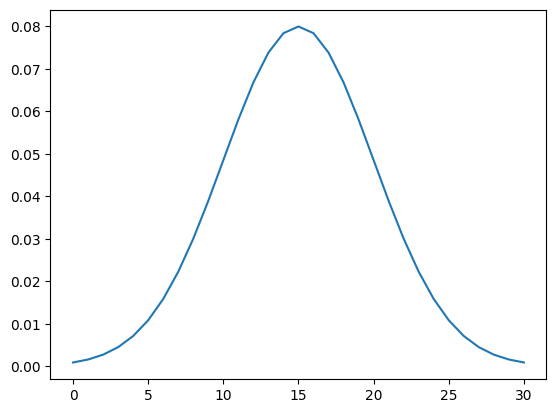

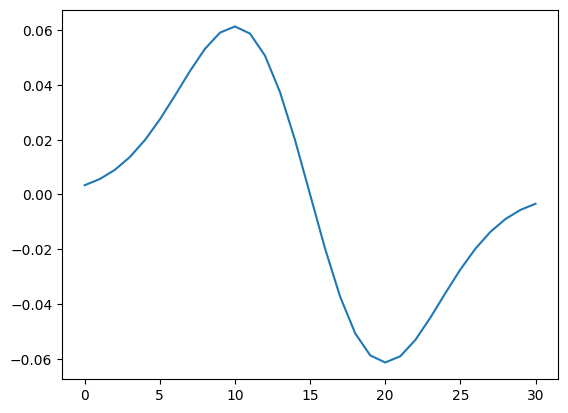

In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2
import a3_utils
import os

def gauss(sigma):
    N = 2 * math.ceil(3 * sigma) + 1

    kernel = []
    for i in range(-N // 2+1, N // 2 + 1):
        value = 1 / (sigma * math.sqrt(2 * math.pi)) * math.exp(-i ** 2 / (2 * sigma ** 2))
        kernel.append(value)
    
    kernel = np.array(kernel)
    kernel /= np.sum(kernel)
    return kernel

def gaussdx(sigma):
    velikost = int(np.ceil(3*sigma))
    x = np.arange(-velikost, velikost+1)
    gx = -x / (np.sqrt(2 * np.pi) * sigma ** 3) * np.exp(-x ** 2 / (2 * sigma ** 2))
    gx /= np.sum(np.abs(gx))
    return gx

plt.plot(gauss(5))
plt.show()
plt.plot(gaussdx(5))
plt.show()

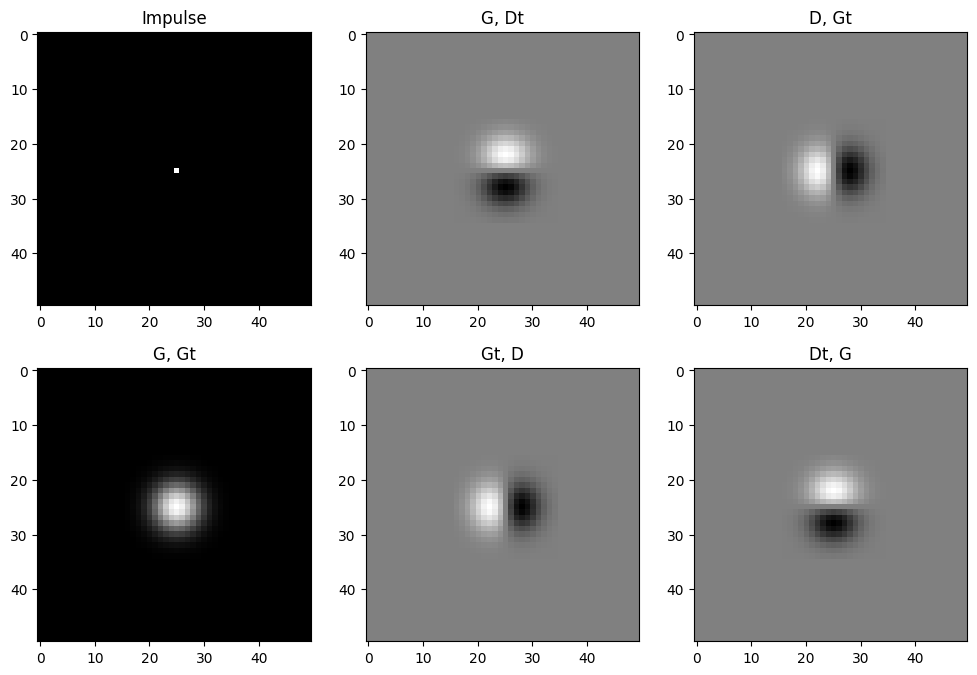

In [18]:
impulse = np.zeros((50,50))
impulse[25,25] = 1

sigma = 3
G = gauss(sigma)
D = gaussdx(sigma)
D = D[::-1]

slika_a = cv2.filter2D(impulse, -1, G[:, None])
slika_a = cv2.filter2D(slika_a, -1, G[None, :])

slika_b = cv2.filter2D(impulse, -1, G[:, None])
slika_b = cv2.filter2D(slika_b, -1, D[None, :]).T

slika_c = cv2.filter2D(impulse, -1, D[:, None])
slika_c = cv2.filter2D(slika_c, -1, G[None, :]).T

slika_d = cv2.filter2D(impulse, -1, G[None, :])
slika_d = cv2.filter2D(slika_d, -1, D[:, None]).T

slika_e = cv2.filter2D(impulse, -1, D[None, :])
slika_e = cv2.filter2D(slika_e, -1, G[:, None]).T

plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(impulse, cmap='gray')
plt.title('Impulse')

plt.subplot(2,3,2)
plt.imshow(slika_b, cmap='gray')
plt.title('G, Dt')

plt.subplot(2,3,3)
plt.imshow(slika_c, cmap='gray')
plt.title('D, Gt')

plt.subplot(2,3,4)
plt.imshow(slika_a, cmap='gray')
plt.title('G, Gt')

plt.subplot(2,3,5)
plt.imshow(slika_d, cmap='gray')
plt.title('Gt, D')

plt.subplot(2,3,6)
plt.imshow(slika_e, cmap='gray')
plt.title('Dt, G')

plt.show()


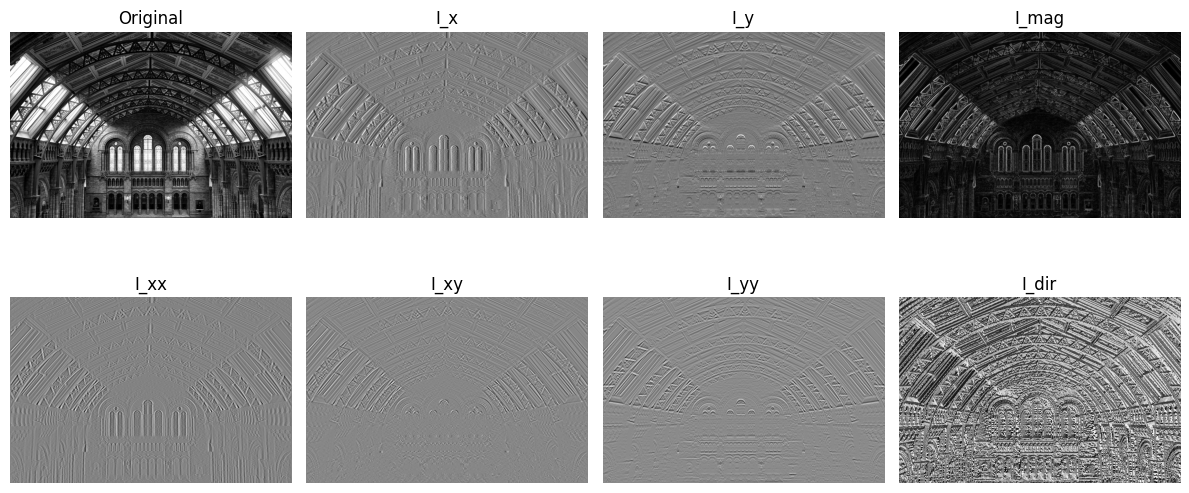

In [19]:
def odvodi(image, sigma):
    G = gauss(sigma)
    D = gaussdx(sigma)
    D = D[::-1]

    Ix = cv2.filter2D(image, -1, D[None, :])
    Iy = cv2.filter2D(image, -1, D[:, None])
    
    Ixx = cv2.filter2D(Ix, -1, D[None, :])
    Ixy = cv2.filter2D(Ix, -1, D[:, None])
    Iyy = cv2.filter2D(Iy, -1, D[:, None])
    
    return Ix, Iy, Ixx, Ixy, Iyy

def gradient_magnitude(image, sigma):
    Ix, Iy , _, _, _ = odvodi(image, sigma)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Iy, Ix)
    return magnitude, angle

image = plt.imread('images/museum.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255

sigma = 1
Ix, Iy, Ixx, Ixy, Iyy = odvodi(image, sigma)
I_mag, I_dir = gradient_magnitude(image, sigma)


plt.figure(figsize=(12, 6))

plt.subplot(2, 4, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(Ix, cmap="gray")
plt.title("I_x")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.imshow(Iy, cmap="gray")
plt.title("I_y")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(I_mag, cmap="gray")
plt.title("I_mag")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(Ixx, cmap="gray")
plt.title("I_xx")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.imshow(Ixy, cmap="gray")
plt.title("I_xy")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.imshow(Iyy, cmap="gray")
plt.title("I_yy")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.imshow(I_dir, cmap="grey")
plt.title("I_dir")
plt.axis("off")

plt.tight_layout()
plt.show()


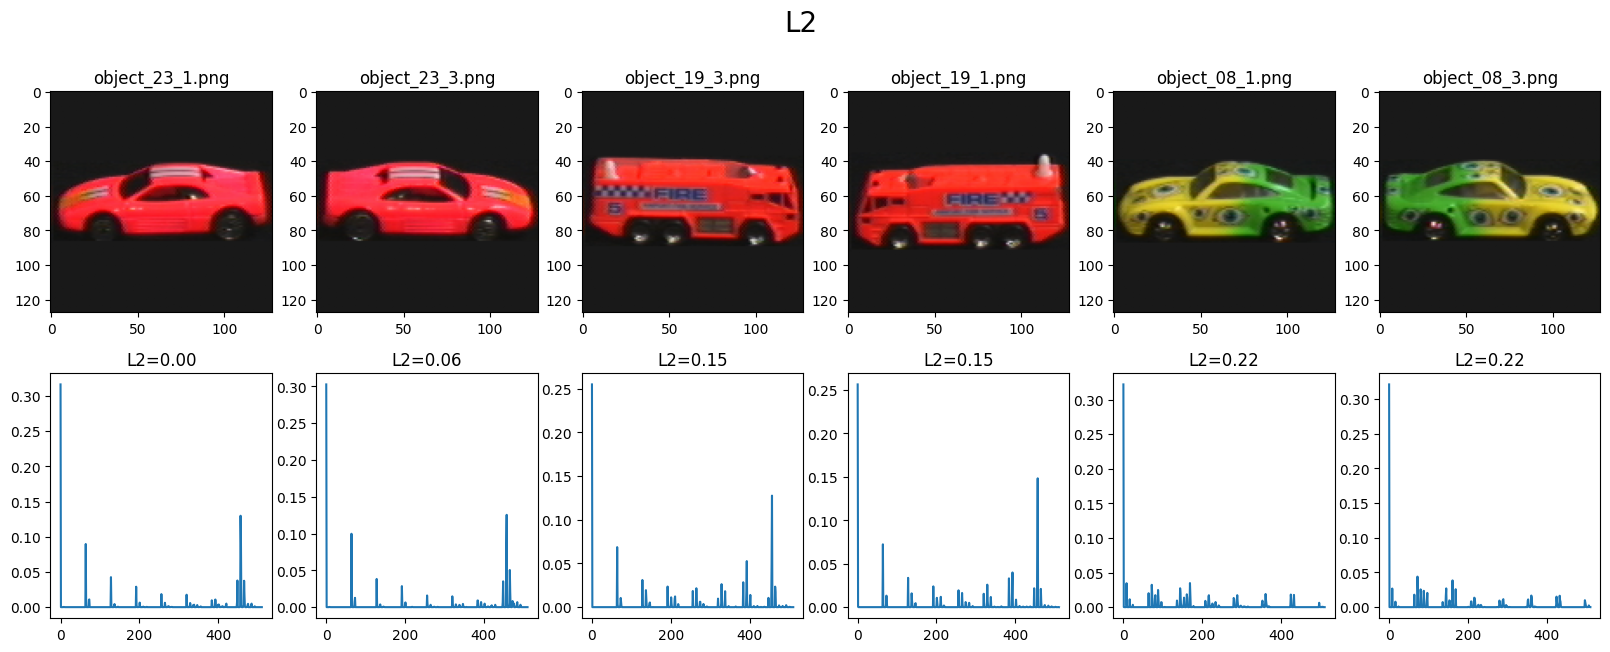

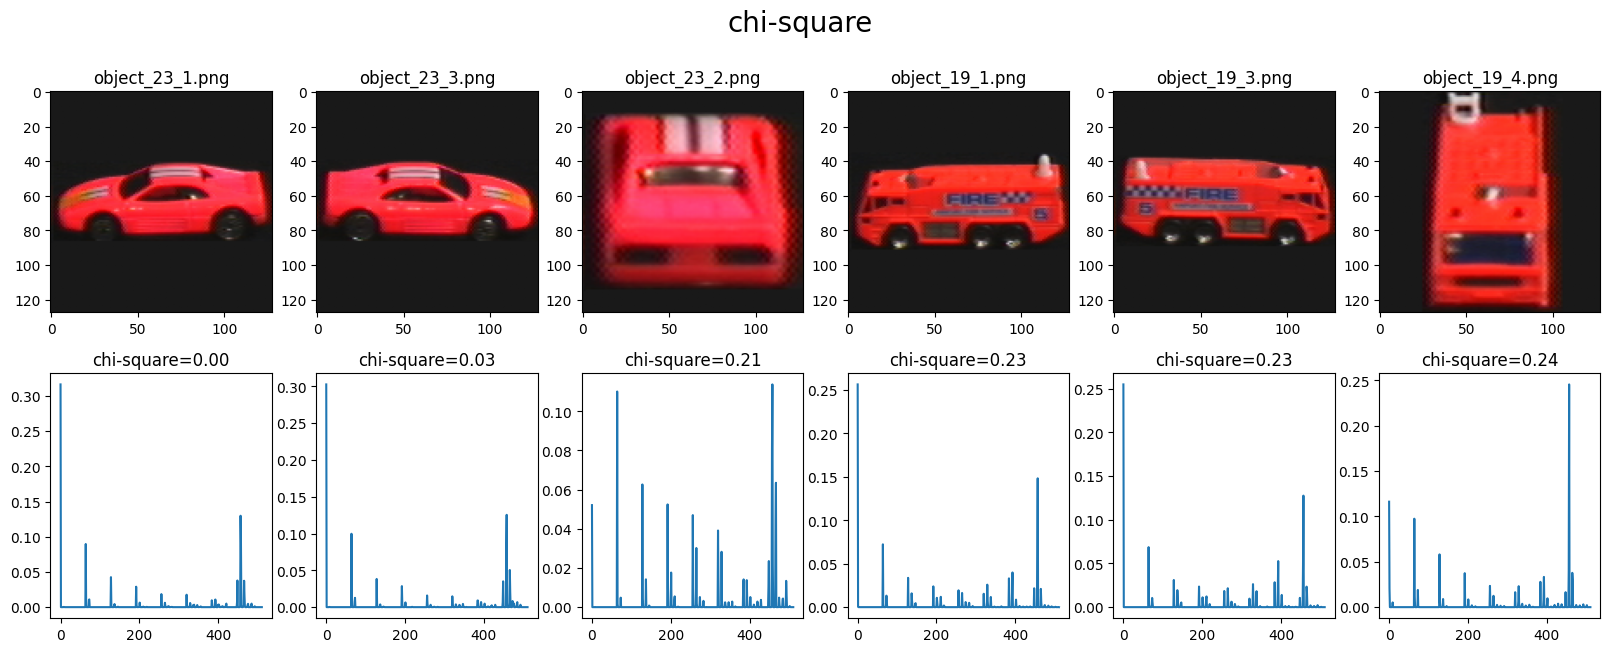

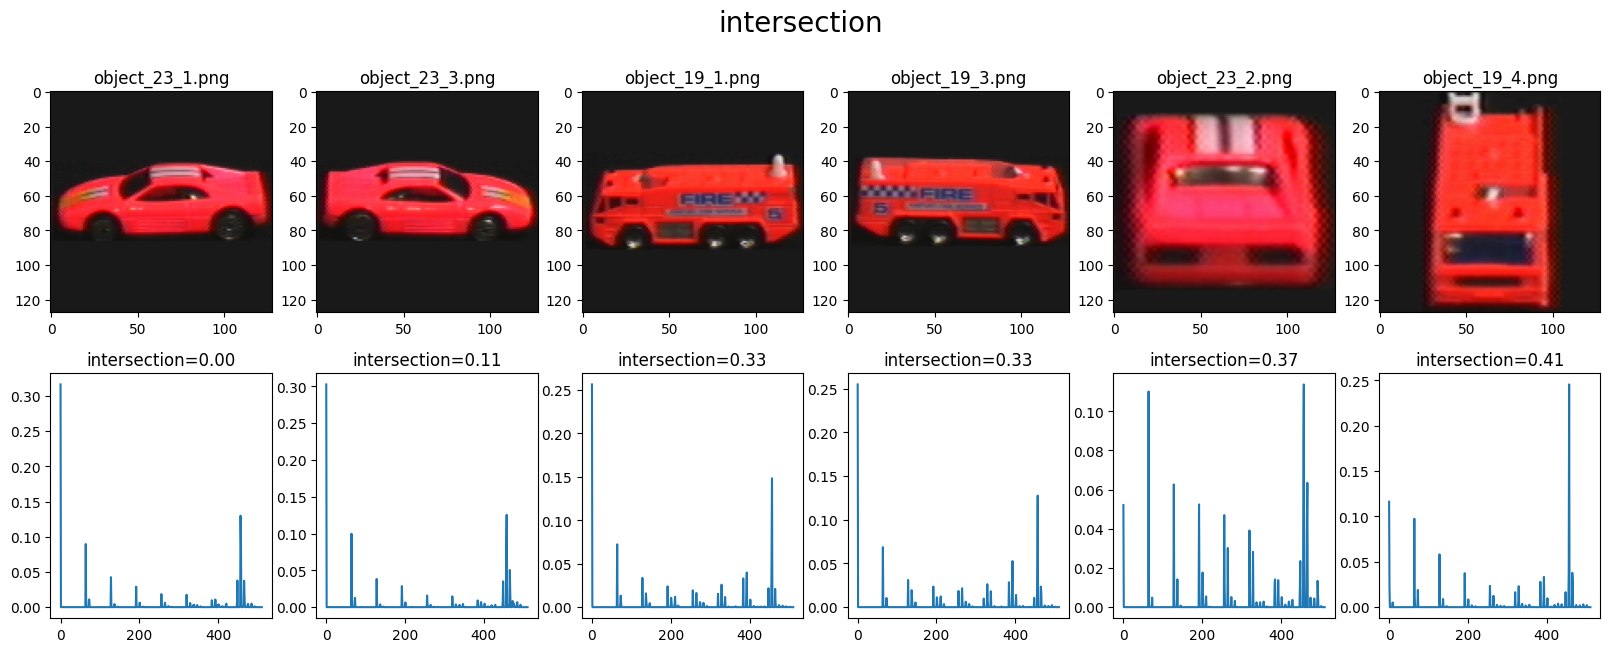

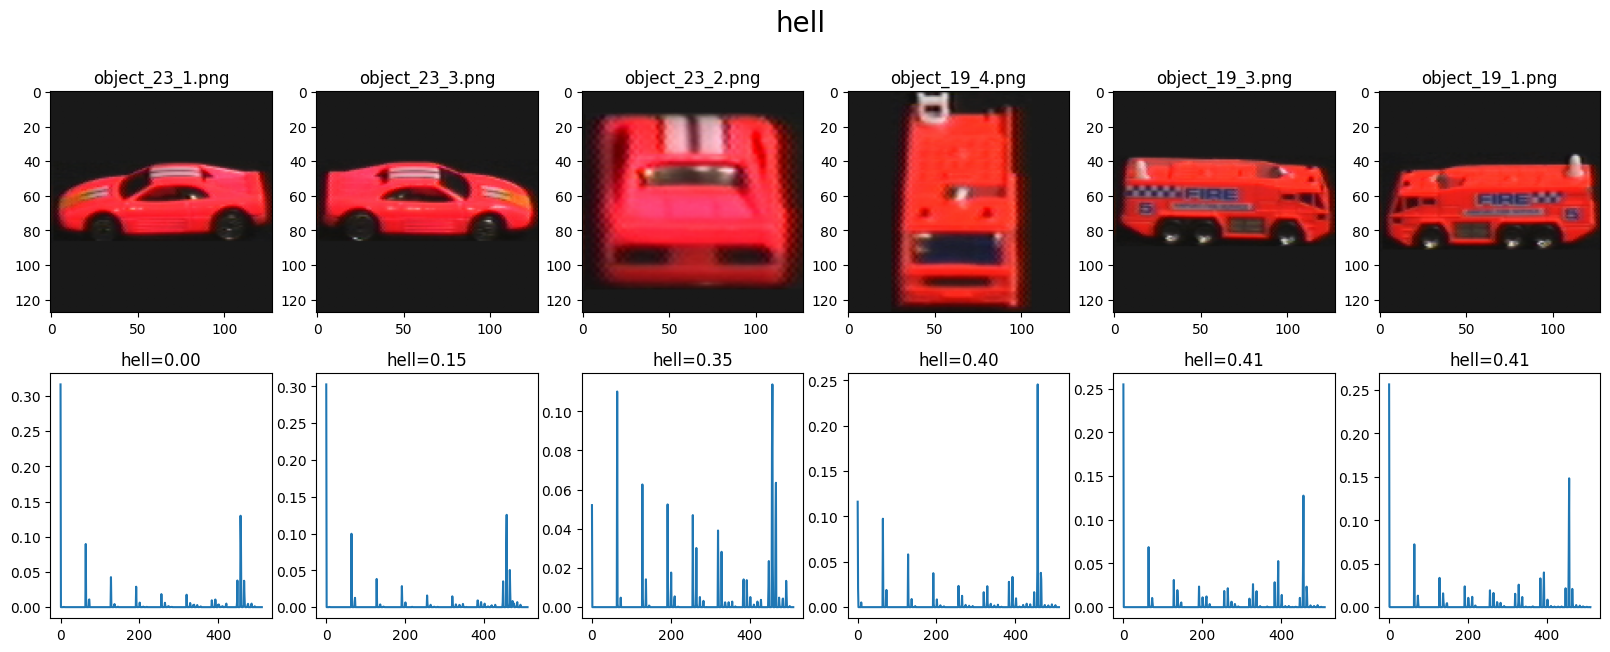

In [20]:
def compare_histograms(h1, h2, metoda):
    assert h1.shape == h2.shape
    
    if metoda == "L2":
        distance = np.sqrt(np.sum((h1 - h2) ** 2))
    
    elif metoda == "chi-square":
        epsilon = 1e-10
        distance = 0.5 * np.sum(((h1 - h2) ** 2) / (h1 + h2 + epsilon))
    
    elif metoda == "intersection":
        distance = 1 - np.sum(np.minimum(h1, h2))
    
    elif metoda == "hell":
        distance = np.sqrt(0.5 * np.sum((np.sqrt(h1) - np.sqrt(h2)) ** 2))
    
    else:
        raise ValueError(f"Napačna metoda: {metoda}")
    
    return distance

def histogram_utezi(histogram, utezi):
    hist_utez = histogram * utezi
    hist_utez /= np.sum(hist_utez)
    return hist_utez

def myhist3(image, n_bins):
    H = np.zeros((n_bins, n_bins, n_bins))

    sirina = 1.0 / n_bins

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            R, G, B = image[i, j]

            r_bin = int(R // sirina)
            g_bin = int(G // sirina)
            b_bin = int(B // sirina)

            if r_bin == n_bins:
                r_bin = n_bins - 1
            if g_bin == n_bins:
                g_bin = n_bins - 1
            if b_bin == n_bins:
                b_bin = n_bins - 1

            H[r_bin, g_bin, b_bin] += 1

    H /= np.sum(H)

    return H

def histogram_all(directory, n_bins):
    histogram = np.zeros(n_bins ** 3)
    for dat in os.listdir(directory):
        if dat.endswith(".png"):
            image_path = os.path.join(directory, dat)
            image = plt.imread(image_path)
            hist = myhist3(image, n_bins).flatten()
            histogram += hist
    
    histogram /= np.sum(histogram)

    return histogram

def image_retrieval(directory, slika, n_bins, utezi = [1]):
    histograms = {}
    slika_hist = myhist3(slika, n_bins).flatten()
    slika_hist = histogram_utezi(slika_hist, utezi)
    
    for dat in os.listdir(directory):
        if dat.endswith(".png"):
            image_path = os.path.join(directory, dat)
            image = plt.imread(image_path)
            hist = myhist3(image, n_bins).flatten()
            hist = histogram_utezi(hist, utezi)
            histograms[dat] = hist
    
    razdalja_metode = ['L2', 'chi-square', 'intersection', 'hell']
    results = {metoda: {} for metoda in razdalja_metode}
    
    for metoda in razdalja_metode:
        for dat, hist in histograms.items():
            results[metoda][dat] = compare_histograms(slika_hist, hist, metoda)
    
    for metoda in razdalja_metode:
        images_sorted = sorted(results[metoda], key=results[metoda].get)
        
        plt.figure(figsize=(20, 7))
        plt.suptitle(f"{metoda}", fontsize=20)
        
        for i, filename in enumerate(images_sorted[:6]):
            plt.subplot(2, 6, i + 1)
            image = plt.imread(os.path.join(directory, filename))
            plt.imshow(image)
            plt.title(f"{filename}")
            
            plt.subplot(2, 6, i + 7)
            plt.plot(histograms[filename])
            plt.title(f"{metoda}={results[metoda][filename]:.2f}")
        
        plt.show()
    
    x = np.arange(len(histograms))

def izracunaj_utezi(histogram, lamda):
    return np.exp(-lamda * histogram)

histogram = histogram_all("../assignment_2/dataset", 8)
lamda = 4
utez = izracunaj_utezi(histogram, lamda)
image = plt.imread("../assignment_2/dataset/object_23_1.png")
image_retrieval("../assignment_2/dataset", image, 8, utezi = utez)



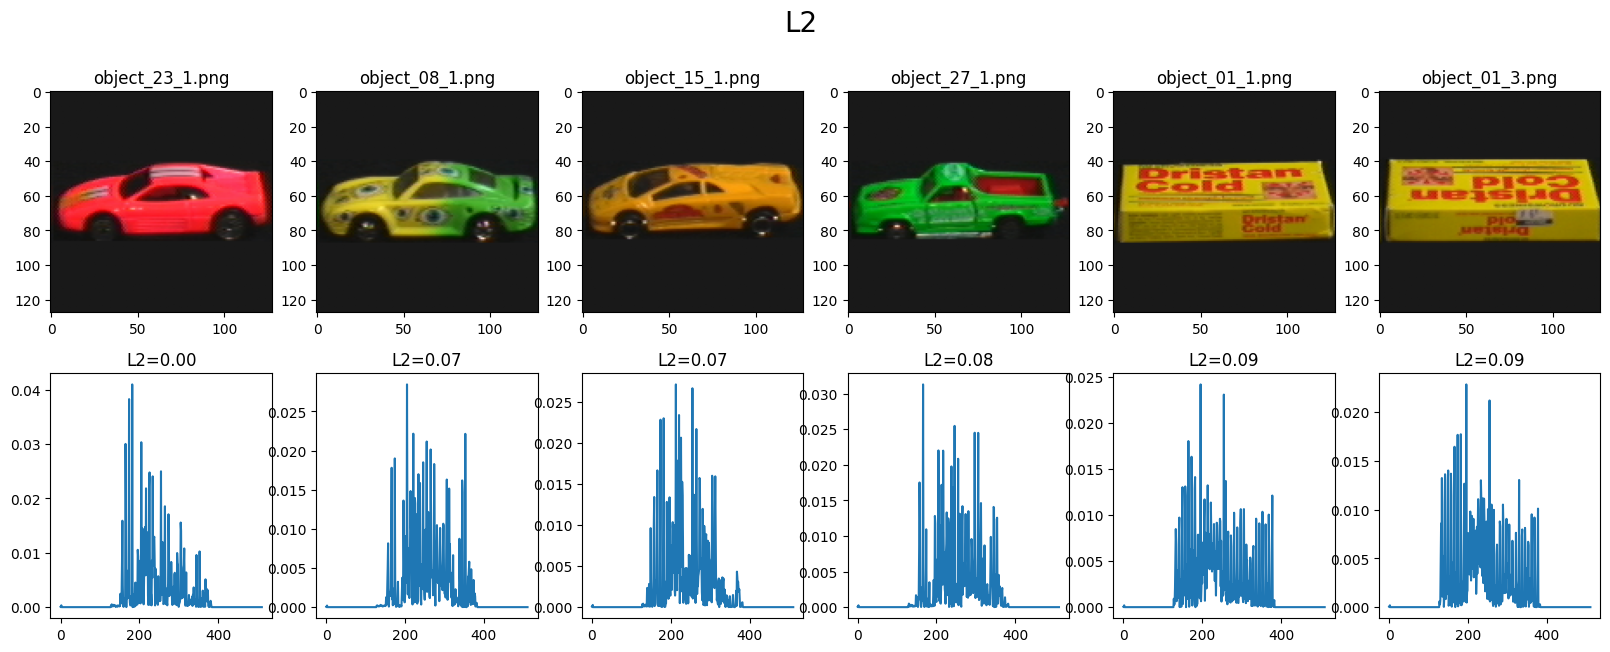

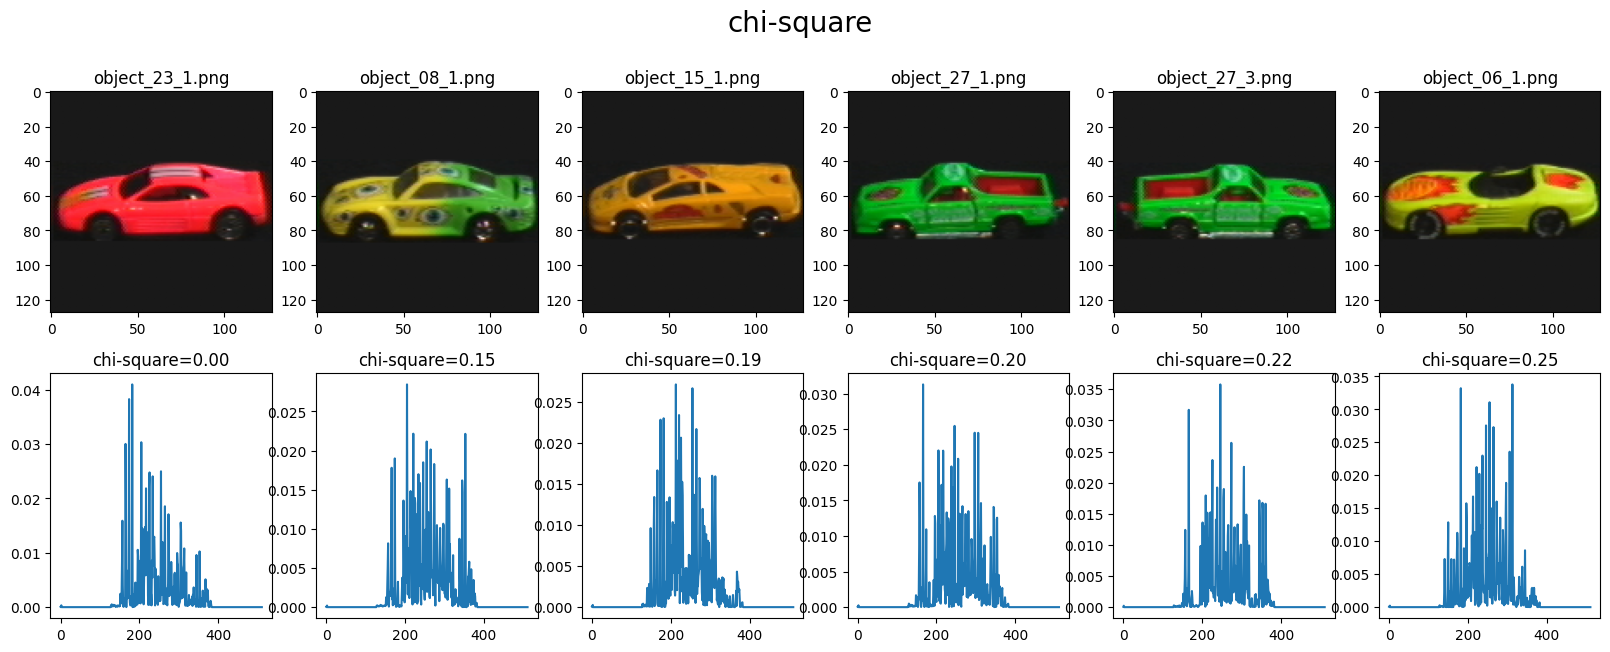

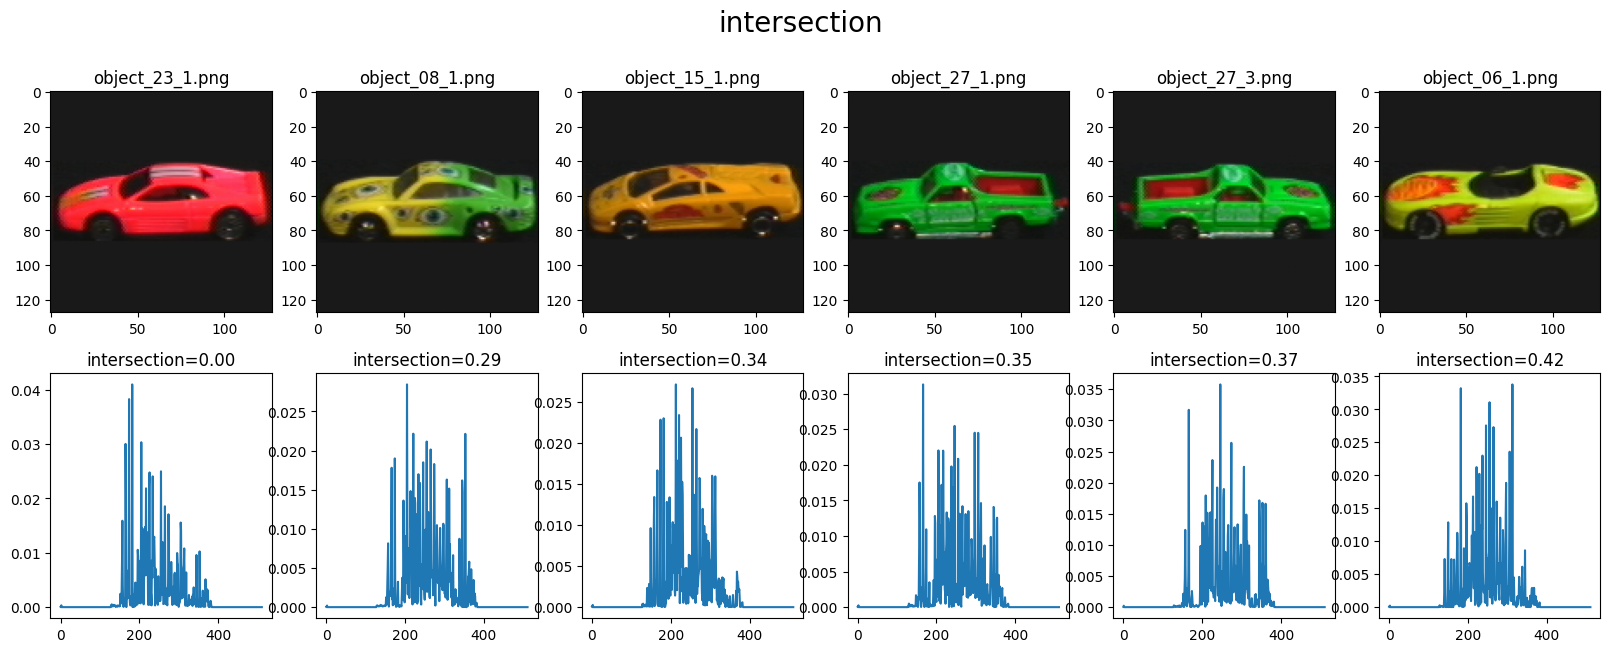

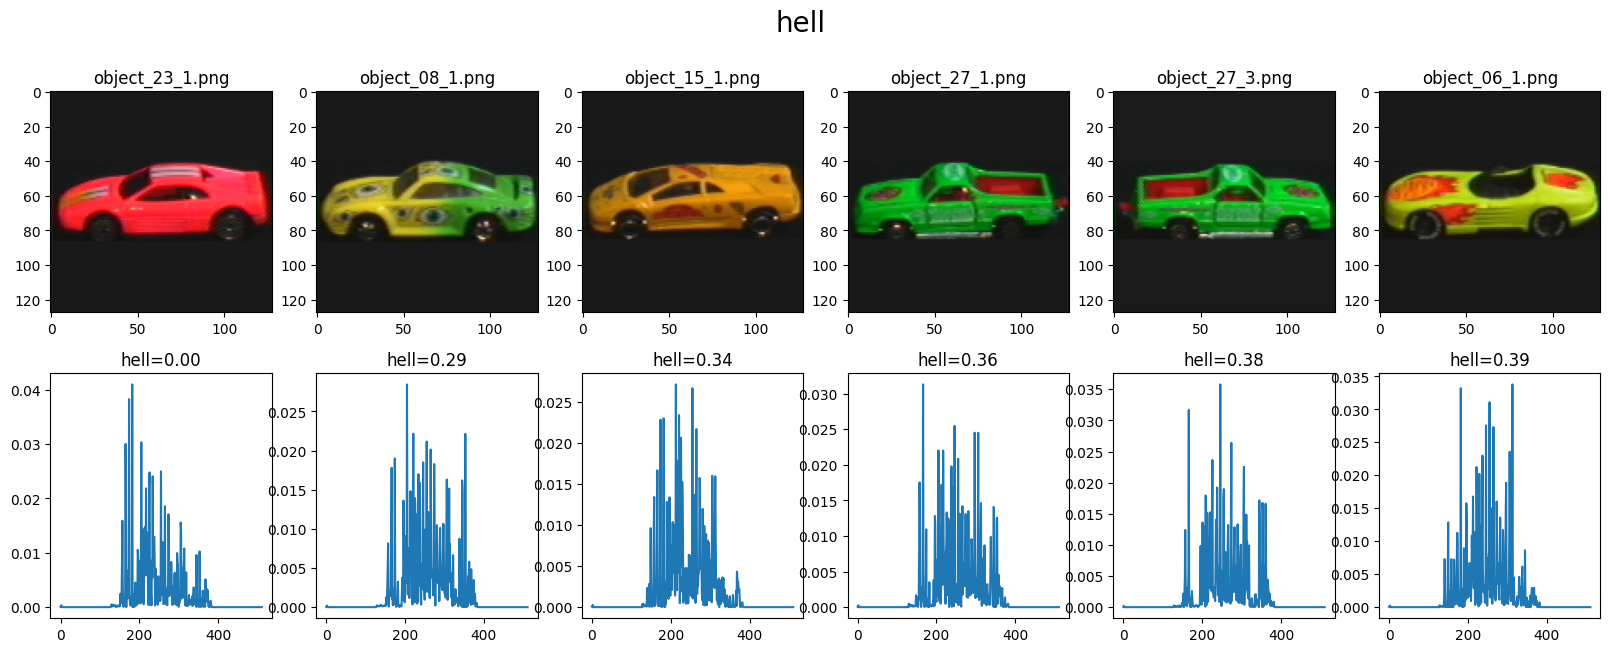

In [21]:
def gradient_histogram(image, sigma):
    magnitude, angle = gradient_magnitude(image, sigma)
    angle = (angle + np.pi) % (2 * np.pi)
    bins = np.linspace(0, 2 * np.pi, 9)
    grad_hist = np.zeros(8)

    for i in range(8):
        mask = (angle >= bins[i]) & (angle < bins[i + 1])
        grad_hist[i] += np.sum(magnitude[mask])

    return grad_hist

def gradient_features(image, sigma):
    h, w = image.shape
    visina = h // 8
    sirina = w // 8
    features = []

    for i in range(8):
        for j in range(8):
            cell = image[i * visina:(i + 1) * visina, j * sirina:(j + 1) * sirina]
            features.extend(gradient_histogram(cell, sigma))

    return np.array(features)

def histogram_all2(directory, n_bins):
    histogram = np.zeros(n_bins ** 3)
    for dat in os.listdir(directory):
        if dat.endswith(".png"):
            image_path = os.path.join(directory, dat)
            image = plt.imread(image_path)
            image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
            features = gradient_features(image_bw, 1).flatten()
            histogram += features
    
    histogram /= np.sum(histogram)

    return histogram

def image_retrieval2(directory, slika, n_bins, utezi = [1]):
    histograms = {}
    image_bw = cv2.cvtColor(slika, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
    features = gradient_features(image_bw, 1).flatten()
    slika_hist = histogram_utezi(features, utezi)
    
    for dat in os.listdir(directory):
        if dat.endswith(".png"):
            image_path = os.path.join(directory, dat)
            image = plt.imread(image_path)
            image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
            features = gradient_features(image_bw, 1).flatten()
            hist = histogram_utezi(features, utezi)
            histograms[dat] = hist
    
    razdalja_metode = ['L2', 'chi-square', 'intersection', 'hell']
    results = {metoda: {} for metoda in razdalja_metode}
    
    for metoda in razdalja_metode:
        for dat, hist in histograms.items():
            results[metoda][dat] = compare_histograms(slika_hist, hist, metoda)
    
    for metoda in razdalja_metode:
        images_sorted = sorted(results[metoda], key=results[metoda].get)
        
        plt.figure(figsize=(20, 7))
        plt.suptitle(f"{metoda}", fontsize=20)
        
        for i, filename in enumerate(images_sorted[:6]):
            plt.subplot(2, 6, i + 1)
            image = plt.imread(os.path.join(directory, filename))
            plt.imshow(image)
            plt.title(f"{filename}")
            
            plt.subplot(2, 6, i + 7)
            plt.plot(histograms[filename])
            plt.title(f"{metoda}={results[metoda][filename]:.2f}")
        
        plt.show()
    
    x = np.arange(len(histograms))

histogram1 = histogram_all2("../assignment_2/dataset", 8)
lamda = 4
utez = izracunaj_utezi(histogram, lamda)
image = plt.imread("../assignment_2/dataset/object_23_1.png")
image_retrieval2("../assignment_2/dataset", image, 8, utezi = utez)


## Exercise 2: Edges in images

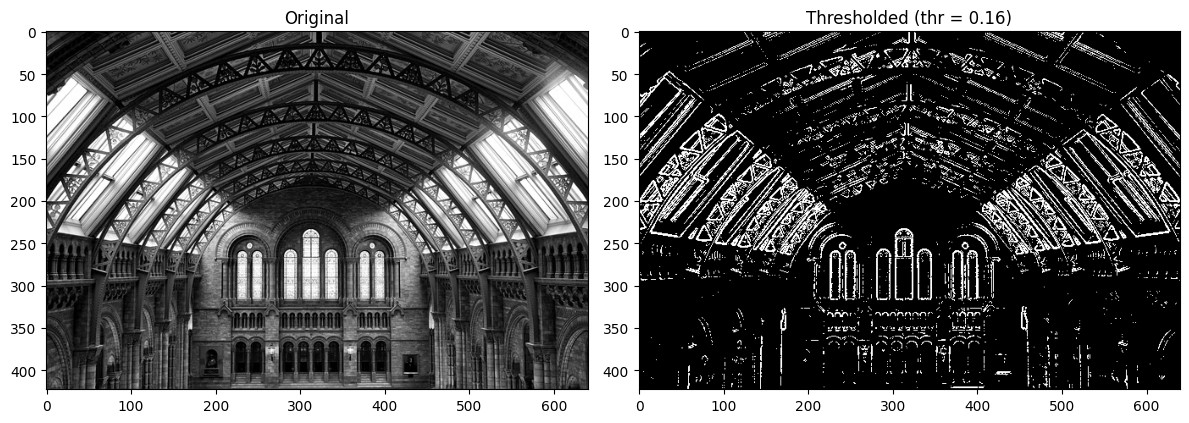

In [22]:
def findedges(image, sigma, theta):
    magnitude, _ = gradient_magnitude(image, sigma)

    edges = np.where(magnitude >= theta, 1, 0) # namesto magnitude sem uporabil 1, ker se boljše vidi

    return edges

image = plt.imread('images/museum.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0

sigma = 1
edges = findedges(image, sigma, 0.16).astype(np.float64)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Thresholded (thr = 0.16)")

plt.tight_layout()
plt.show()

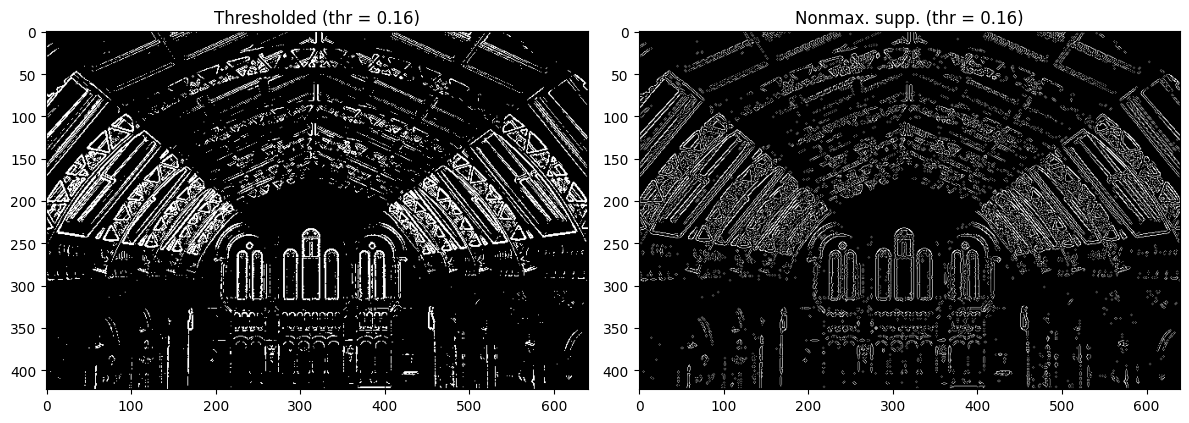

In [23]:
def non_maxima_suppression(magnitude, angle):
    nms = np.zeros_like(magnitude)
    angle = angle * 180.0 / np.pi
    angle[angle < 0] += 180 # Samo pozitivni koti

    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            q, r = 1, 1
            
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = magnitude[i, j + 1] # horizontalno
                r = magnitude[i, j - 1]
            elif 22.5 <= angle[i, j] < 67.5:
                q = magnitude[i + 1, j + 1] # diagonalno
                r = magnitude[i - 1, j - 1]
            elif 67.5 <= angle[i, j] < 112.5:
                q = magnitude[i + 1, j] # vertikalno
                r = magnitude[i - 1, j]
            elif 112.5 <= angle[i, j] < 157.5:
                q = magnitude[i + 1, j - 1] # diagonalno
                r = magnitude[i - 1, j + 1]

            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                nms[i, j] = magnitude[i, j]
            else:
                nms[i, j] = 0
    
    return nms

image = plt.imread('images/museum.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0

edges = findedges(image, 1, 0.16).astype(np.float64)
magnitude, angle = gradient_magnitude(edges, 1)

nms = non_maxima_suppression(magnitude, angle)
#nms = np.where(nms > 0.16, 1, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap="gray")
plt.title("Thresholded (thr = 0.16)")

plt.subplot(1, 2, 2)
plt.imshow(nms, cmap="gray")
plt.title("Nonmax. supp. (thr = 0.16)")

plt.tight_layout()
plt.show()


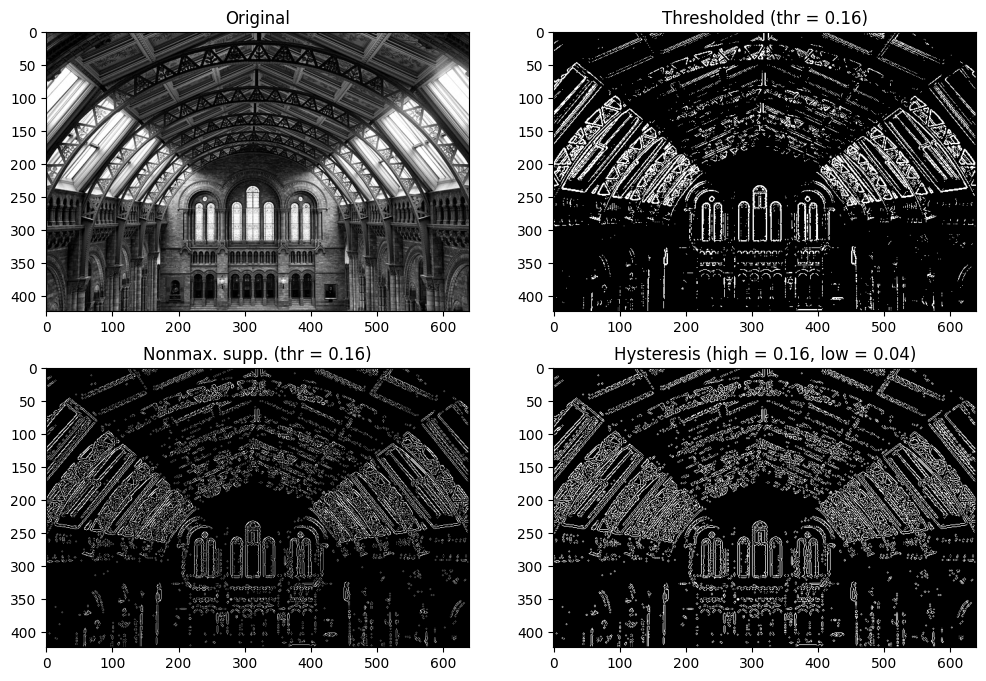

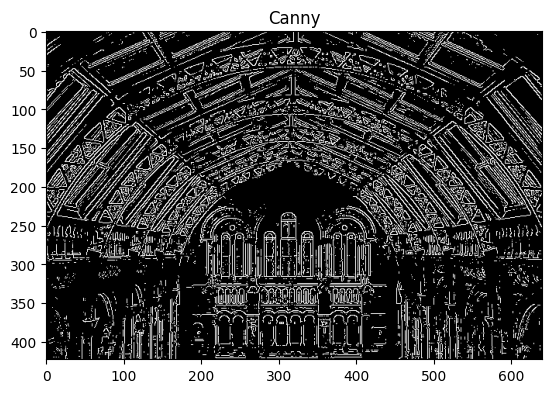

In [24]:
def hysteresis_thresholding_optimized(image, t_low, t_high):
    t_low = t_low * 255
    t_high = t_high * 255
    result = np.zeros_like(image, dtype=np.uint8)
    image = (image * 255).astype(np.uint8)

    strong_edges = (image > t_high).astype(np.uint8)
    weak_edges = ((image > t_low) & (image < t_high)).astype(np.uint8)

    result[strong_edges == 1] = 1
    
    num_labels, labels, _, _ = cv2.connectedComponentsWithStats(strong_edges, connectivity=8)

    
    for label in range(1, num_labels):
        mask = (labels == label)
        if (weak_edges[mask]).any():
            result[mask] = 1

    result = result.astype(np.float64) / 255.0
    return result

def vse_skupaj(image, low, high):
    edges = findedges(image, 1, high).astype(np.float64)
    magnitude, angle = gradient_magnitude(edges, 1)
    nms = non_maxima_suppression(magnitude, angle)
    hysteresis = hysteresis_thresholding_optimized(nms, low, high)
    return hysteresis

image = plt.imread('images/museum.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
high = 0.16
low = 0.04

hysteresis = vse_skupaj(image, low, high)

test = cv2.Canny((image * 255).astype(np.uint8), 250, 255) / 255.0

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")

plt.subplot(2, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Thresholded (thr = 0.16)")

plt.subplot(2, 2, 3)
plt.imshow(nms, cmap="gray")
plt.title("Nonmax. supp. (thr = 0.16)")

plt.subplot(2, 2, 4)
plt.imshow(hysteresis, cmap="gray")
plt.title("Hysteresis (high = 0.16, low = 0.04)")

#plt.tight_layout()
plt.show()

plt.imshow(test, cmap='gray')
plt.title('Canny')
plt.show()


## Exercise 3: Detecting lines

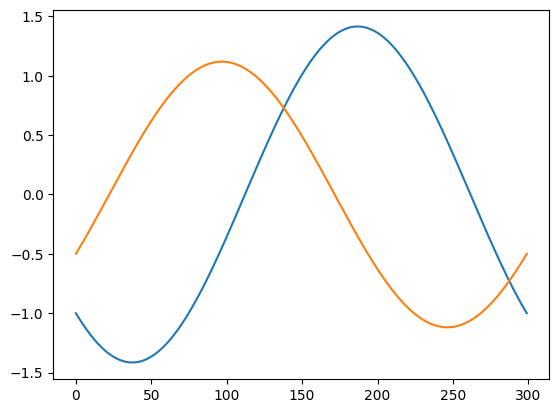

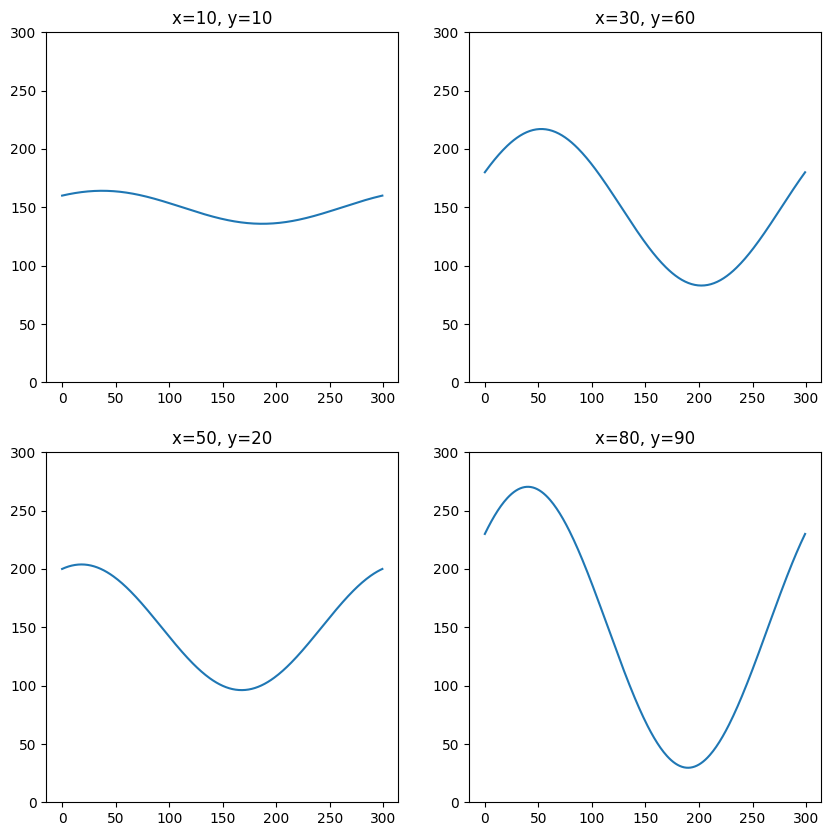

In [25]:
def hough_accumulator_point(x, y, bins):
    theta = np.linspace(-np.pi, np.pi, bins)
    acc = np.zeros(bins)
    for i in range(bins):
        r = x*np.cos(theta[i]) + y*np.sin(theta[i])
        acc[i] = r
    return acc

def hough_accumulator_point2(x, y, bins):
    theta = np.linspace(0, 2*np.pi, bins)	
    acc = np.zeros(bins)
    for i in range(bins):
        r = x*np.cos(theta[i]) + y*np.sin(theta[i])
        acc[i] = r
    return acc

acc1 = hough_accumulator_point(1, 1, 300)
acc2 = hough_accumulator_point(0.5, -1, 300)
acc3 = hough_accumulator_point2(10, 10, 300) + 150
acc4 = hough_accumulator_point2(30, 60, 300) + 150
acc5 = hough_accumulator_point2(50, 20, 300) + 150
acc6 = hough_accumulator_point2(80, 90, 300) + 150

plt.plot(acc1)
plt.plot(acc2)
plt.show()

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(acc3)
plt.title('x=10, y=10')

plt.subplot(2, 2, 2)
plt.plot(acc4)
plt.title('x=30, y=60')

plt.subplot(2, 2, 3)
plt.plot(acc5)
plt.title('x=50, y=20')

plt.subplot(2, 2, 4)
plt.plot(acc6)
plt.title('x=80, y=90')

for ax in plt.gcf().get_axes():
    ax.set_ylim(0, 300)

plt.show()

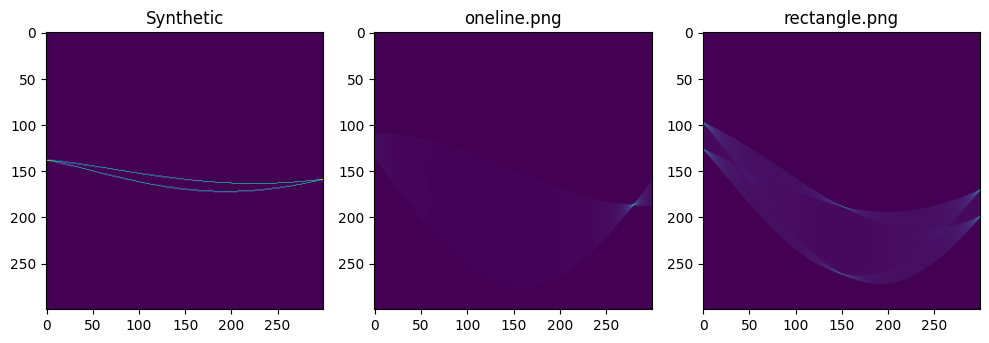

In [26]:
def hough_find_lines(edge_image, theta_bins=300, rho_bins=300, threshold = 0.5):
    h, w = edge_image.shape
    diag = int(np.sqrt(h**2 + w**2))
    theta = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
    rho = np.linspace(-diag, diag, rho_bins)
    
    accumulator = np.zeros((rho_bins, theta_bins))
    
    y_e, x_e = np.nonzero(edge_image)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    for x, y in zip(x_e, y_e):
        rhos = x * cos_theta + y * sin_theta
        rho_indexs = np.digitize(rhos, rho) - 1
        
        valid = (rho_indexs >= 0) & (rho_indexs < rho_bins)
        accumulator[rho_indexs[valid], np.arange(theta_bins)[valid]] += 1
        
        #print (x, y)

    lines = []

    for r, t, in zip(*np.where(accumulator > threshold)):
        lines.append((rho[r], theta[t]))
    
    return accumulator, theta, rho, lines

synthetic_image = np.zeros((100, 100))
synthetic_image[10, 10] = 1
synthetic_image[10, 20] = 1
image_rectangle_e = cv2.Canny((synthetic_image * 255).astype(np.uint8), 10, 200) / 255.0

image_oneline = plt.imread('images/oneline.png')
image_oneline = cv2.cvtColor(image_oneline, cv2.COLOR_BGR2GRAY).astype(np.float64)
image_oneline_e = cv2.Canny((image_oneline * 255).astype(np.uint8), 100, 150) / 255.0

image_rectangle = plt.imread('images/rectangle.png')
image_rectangle = cv2.cvtColor(image_rectangle, cv2.COLOR_BGR2GRAY).astype(np.float64)
image_rectangle_e = cv2.Canny((image_rectangle * 255).astype(np.uint8), 100, 150) / 255.0

acc1, _ , _ , _= hough_find_lines(synthetic_image)
acc2, _ , _ , _= hough_find_lines(image_oneline_e)
acc3, _ , _ , _= hough_find_lines(image_rectangle_e)

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(acc1)
plt.title('Synthetic')

plt.subplot(1, 3, 2)
plt.imshow(acc2)
plt.title('oneline.png')

plt.subplot(1, 3, 3)
plt.imshow(acc3)
plt.title('rectangle.png')

plt.tight_layout()
plt.show()


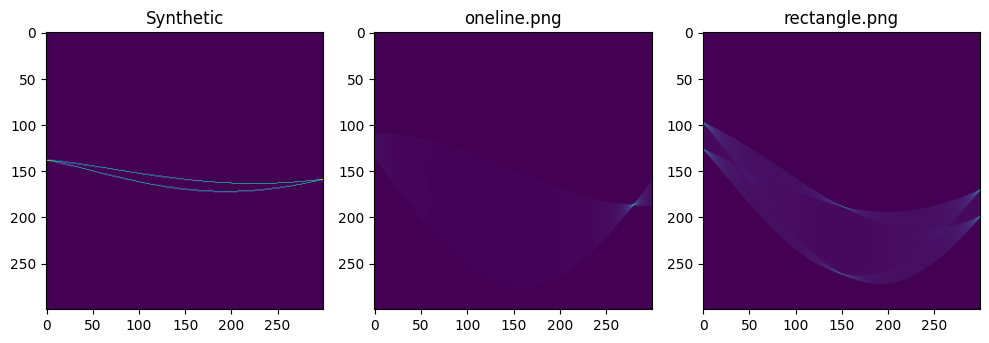

In [27]:
def nonmaxima_suppression_box(edge):
    suppressed = np.copy(edge)
    rows, cols = edge.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            local_max = np.max(edge[i-1:i+2, j-1:j+2])
            if edge[i, j] != local_max:
                suppressed[i, j] = 0

    return suppressed

synthetic_image = nonmaxima_suppression_box(synthetic_image)
image_oneline_e = nonmaxima_suppression_box(image_oneline_e)
image_rectangle_e = nonmaxima_suppression_box(image_rectangle_e)

acc1, _ , _ , _= hough_find_lines(synthetic_image)
acc2, _ , _ , _= hough_find_lines(image_oneline_e)
acc3, _ , _ , _= hough_find_lines(image_rectangle_e)

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(acc1)
plt.title('Synthetic')

plt.subplot(1, 3, 2)
plt.imshow(acc2)
plt.title('oneline.png')

plt.subplot(1, 3, 3)
plt.imshow(acc3)
plt.title('rectangle.png')

plt.tight_layout()
plt.show()


10
2
32


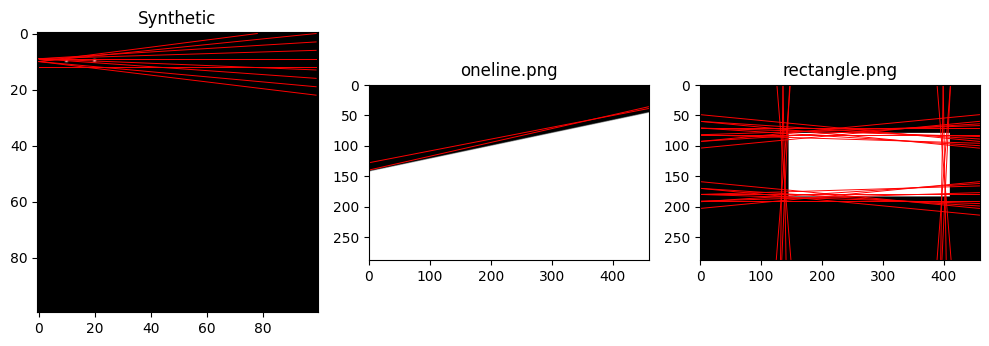

In [28]:
def extract_lines(image, rho, theta, lines):
    h , w = image.shape
    #print(h, w)

    for r, t in lines:
        a3_utils.draw_line(r, t, h, w)
    


acc1, theta1, rho1, lines1 = hough_find_lines(synthetic_image, theta_bins = 100, rho_bins = 100, threshold = 1)
acc2, theta2, rho2, lines2 = hough_find_lines(image_oneline_e, theta_bins = 100, rho_bins = 100, threshold = 300)
acc3, theta3, rho3, lines3 = hough_find_lines(image_rectangle_e, theta_bins = 100, rho_bins = 100, threshold = 100)

print(len(lines1))
print(len(lines2))
print(len(lines3))

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(synthetic_image, cmap='gray')
extract_lines(synthetic_image, rho1, theta1, lines1)
plt.title('Synthetic')

plt.subplot(1, 3, 2)
plt.imshow(image_oneline, cmap='gray')
extract_lines(image_oneline, rho2, theta2, lines2)
plt.title('oneline.png')

plt.subplot(1, 3, 3)
plt.imshow(image_rectangle, cmap='gray')
extract_lines(image_rectangle, rho3, theta3, lines3)
plt.title('rectangle.png')

plt.tight_layout()
plt.show()

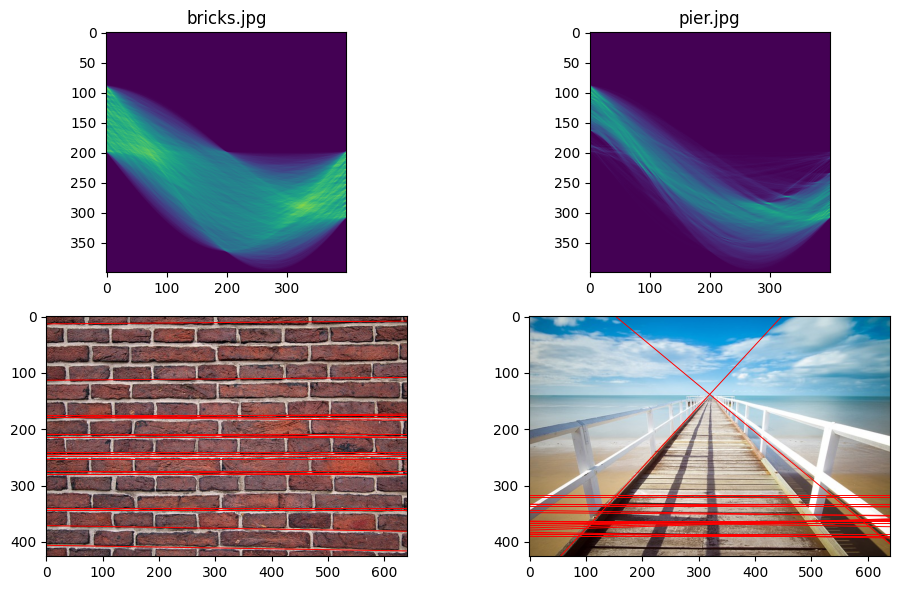

In [29]:
def hough_find_lines_top(edge_image, theta_bins=300, rho_bins=300, n = 10):
    h, w = edge_image.shape
    diag = int(np.sqrt(h**2 + w**2))
    theta = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
    rho = np.linspace(-diag, diag, rho_bins)
    
    accumulator = np.zeros((rho_bins, theta_bins))
    
    y_e, x_e = np.nonzero(edge_image)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    for x, y in zip(x_e, y_e):
        rhos = x * cos_theta + y * sin_theta
        rho_indexs = np.digitize(rhos, rho) - 1
        
        valid = (rho_indexs >= 0) & (rho_indexs < rho_bins)
        accumulator[rho_indexs[valid], np.arange(theta_bins)[valid]] += 1
        
        #print (x, y)

    line_index = np.argpartition(accumulator.flatten(), -n)[-n:]
    line_index = line_index[np.argsort(accumulator.flatten()[line_index])[::-1]]
    
    lines = []
    for index in line_index:
        rho_index, theta_index = np.unravel_index(index, accumulator.shape)
        r = rho[rho_index]
        t = theta[theta_index]
        lines.append((r, t))
    
    return accumulator, theta, rho, lines

image_bricks = plt.imread('images/bricks.jpg')
image_bricks_e = cv2.cvtColor(image_bricks, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
image_bricks_e = cv2.Canny((image_bricks_e * 255).astype(np.uint8), 100, 150) / 255.0

image_pier = plt.imread('images/pier.jpg')
image_pier_e = cv2.cvtColor(image_pier, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
image_pier_e = cv2.Canny((image_pier_e * 255).astype(np.uint8), 100, 150) / 255.0

acc1, theta1, rho1, lines1 = hough_find_lines_top(image_bricks_e, theta_bins = 400, rho_bins = 400, n = 20)
acc2, theta2, rho2, lines2 = hough_find_lines_top(image_pier_e, theta_bins = 400, rho_bins = 400, n = 20)

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.imshow(acc1)
plt.title('bricks.jpg')

plt.subplot(2,2,2)
plt.imshow(acc2)
plt.title('pier.jpg')

plt.subplot(2, 2, 3)
plt.imshow(image_bricks)
extract_lines(image_bricks_e, rho1, theta1, lines1)

plt.subplot(2, 2, 4)
plt.imshow(image_pier)
extract_lines(image_pier_e, rho2, theta2, lines2)

plt.tight_layout()
plt.show()

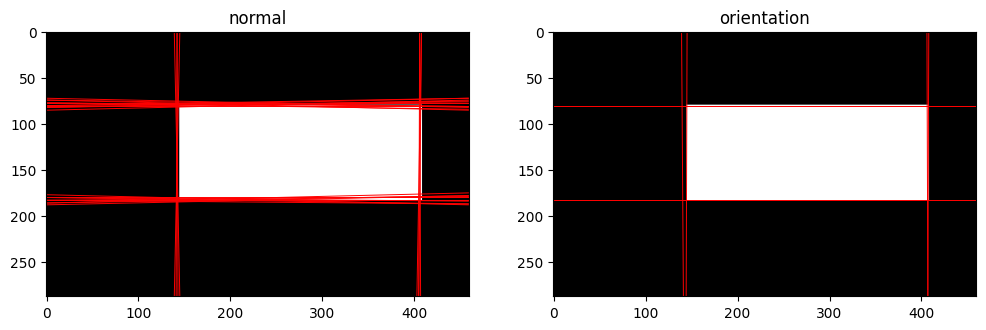

In [30]:
def hough_find_lines_with_gradient(edge_image, gradient_angles, theta_bins=400, rho_bins=400, n=10):
    h, w = edge_image.shape
    diag = int(np.sqrt(h**2 + w**2))
    theta = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
    rho = np.linspace(-diag, diag, rho_bins)
    
    accumulator = np.zeros((rho_bins, theta_bins))
    
    y_e, x_e = np.nonzero(edge_image)
    
    for x, y in zip(x_e, y_e):
        angle = gradient_angles[y, x]
        if angle < -np.pi / 2:
            angle += np.pi
        elif angle > np.pi / 2:
            angle -= np.pi
        
        theta_index = np.argmin(np.abs(theta - angle))
        #print(angle, theta_index, theta[theta_index])
        
        rho_val = (x) * np.cos(theta[theta_index]) + y * np.sin(theta[theta_index])
        rho_index = np.digitize(rho_val, rho) - 1
        #print(theta_index, angle, rho_val, rho_index)
        
        if 0 <= rho_index < rho_bins:
            accumulator[rho_index, theta_index] += 1
        else:
            print(rho_index)

    line_index = np.argpartition(accumulator.flatten(), -n)[-n:]
    line_index = line_index[np.argsort(accumulator.flatten()[line_index])[::-1]]
    
    lines = []
    for index in line_index:
        rho_index, theta_index = np.unravel_index(index, accumulator.shape)
        r = rho[rho_index]
        t = theta[theta_index]
        #print(accumulator[rho_index, theta_index], r, t)
        lines.append((r, t))
    
    return accumulator, theta, rho, lines

image = plt.imread("images/rectangle.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64)
#print(image)
edges = vse_skupaj(image, 0.1, 0.2) * 255
h, w = image.shape

magnitude, angles = gradient_magnitude(edges, 1)

accumulator, theta, rho, lines = hough_find_lines_with_gradient(edges, angles, n = 8)
acc2, theta2, rho2, lines2 = hough_find_lines_top(image_rectangle_e, theta_bins=400, rho_bins=400, n = 30)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(image, cmap = 'grey')
extract_lines(image, rho2, theta2, lines2)
plt.title('normal')

plt.subplot(1,2,2)
plt.imshow(image, cmap = 'grey')
extract_lines(image, rho, theta, lines)
plt.title('orientation')

plt.show()
    

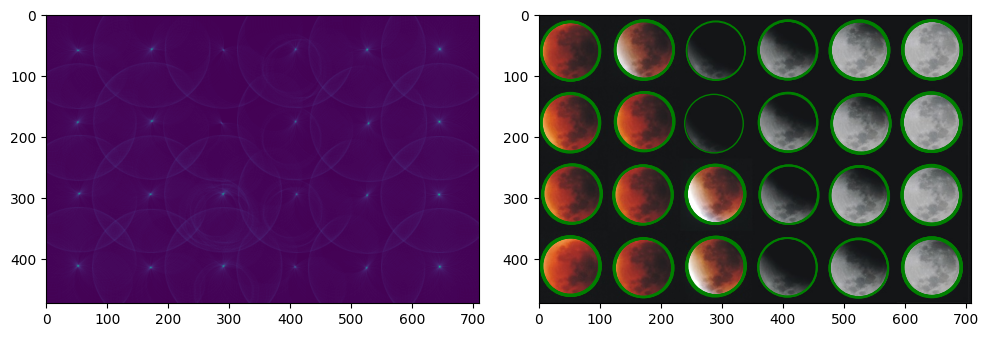

In [ ]:
def hough_krogi(edge_image, radius, n=10):
    h, w = edge_image.shape
    accumulator = np.zeros((h, w))
    
    y_e, x_e = np.nonzero(edge_image)
    
    for x, y in zip(x_e, y_e):
        for theta in np.linspace(0, 2 * np.pi, 360):
            a = int(x - radius * np.cos(theta)) # x = a + cos(theta)
            b = int(y - radius * np.sin(theta)) # y = b + sin(theta)
            if 0 <= a < w and 0 <= b < h:
                accumulator[b, a] += 1
    
    circle_index = np.argpartition(accumulator.flatten(), -n)[-n:]
    circle_index = circle_index[np.argsort(accumulator.flatten()[circle_index])[::-1]]
    
    circles = []
    for index in circle_index:
        y_center, x_center = np.unravel_index(index, accumulator.shape)
        circles.append((x_center, y_center))
    
    return accumulator, circles

image = plt.imread('images/eclipse.jpg')
image_e = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(image_e, 100, 200)

radius = 48
accumulator, circles = hough_krogi(edges, radius, n=200)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(accumulator)

plt.subplot(1, 2, 2)
plt.imshow(image)
ax = plt.gca()
for x_center, y_center in circles:
    circle = plt.Circle((x_center, y_center), radius, color='green', fill=False, linewidth=1)
    ax.add_patch(circle)

plt.tight_layout()
plt.show()


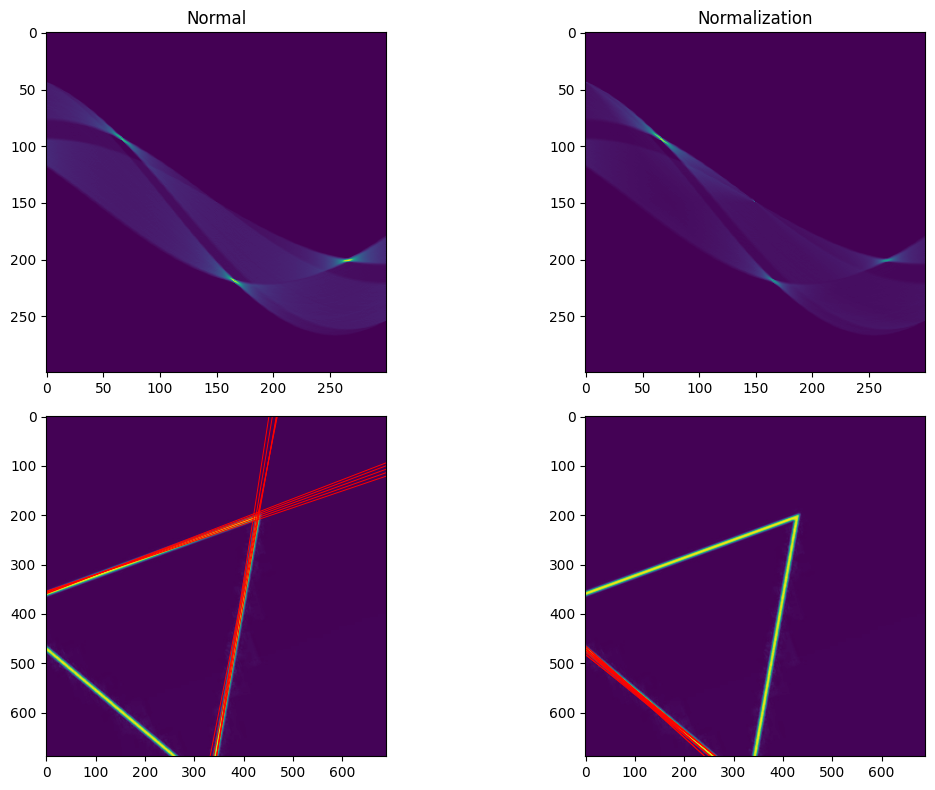

In [32]:
def dolzina_premice(rho, theta, w, h):

    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    tocke = []

    if cos_t != 0:
        tocke.append((rho / cos_t, 0))
        tocke.append(((rho - h * sin_t) / cos_t, h))
    
    if sin_t != 0:
        tocke.append((0, rho / sin_t))
        tocke.append((w, (rho - w * cos_t) / sin_t))
    
    tocke_valid = [(x, y) for x, y in tocke if 0 <= x <= w and 0 <= y <= h]
    
    #print('tocke_valid: ', tocke_valid[:2], 'a3_utils: ', xs[:2], ys[:2])

    if len(tocke_valid) >= 2:
        x1, y1 = tocke_valid[0]
        x2, y2 = tocke_valid[1]
        rez = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        return rez
    else:
        return 0

def hough_find_lines_length_normalized(edge_image, theta_bins=300, rho_bins=300, n=10):
    h, w = edge_image.shape
    #print(h,w)
    diag = int(np.sqrt(h**2 + w**2))
    theta = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
    rho = np.linspace(-diag, diag, rho_bins)
    
    accumulator = np.zeros((rho_bins, theta_bins))
    line_lengths = np.zeros((rho_bins, theta_bins))
    
    y_e, x_e = np.nonzero(edge_image)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    for x, y in zip(x_e, y_e):
        rhos = x * cos_theta + y * sin_theta
        rho_indexs = np.digitize(rhos, rho) - 1
        
        valid = (rho_indexs >= 0) & (rho_indexs < rho_bins)
        accumulator[rho_indexs[valid], np.arange(theta_bins)[valid]] += 1
    
    for theta_index, t in enumerate(theta):
        for rho_index, r in enumerate(rho):
            dol = dolzina_premice(r,t,w,h)
            #print(dol)
            line_lengths[rho_index, theta_index] = dol
            if dol > 0 and accumulator[rho_index, theta_index] > 0:
                #print( accumulator[rho_index, theta_index], dol)
                accumulator[rho_index, theta_index] /= dol
            else:
                accumulator[rho_index, theta_index] = 0

    line_index = np.argpartition(accumulator.flatten(), -n)[-n:]
    line_index = line_index[np.argsort(accumulator.flatten()[line_index])[::-1]]
    
    lines = []
    for index in line_index:
        rho_index, theta_index = np.unravel_index(index, accumulator.shape)
        r = rho[rho_index]
        t = theta[theta_index]
        #print(accumulator[rho_index, theta_index])
        lines.append((r, t))
    
    return accumulator, theta, rho, lines
   
    
image = plt.imread('trikotnik.jpg')
image_e = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
#edges = cv2.Canny((image_e * 255).astype(np.uint8), 100, 150) / 255.0
edges = vse_skupaj(image_e, 0.04, 0.16)

n = 10
acc1, theta1, rho1, lines1 = hough_find_lines_top(edges, theta_bins=300, rho_bins=300, n=n)
acc2, theta2, rho2, lines2 = hough_find_lines_length_normalized(edges, theta_bins=300, rho_bins=300, n=n)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Normal')
plt.imshow(acc1)

plt.subplot(2, 2, 2)
plt.title('Normalization')
plt.imshow(acc2)

plt.subplot(2, 2, 3)
plt.imshow(image_e)
extract_lines(edges, rho1, theta1, lines1)

plt.subplot(2, 2, 4)
plt.imshow(image_e)
extract_lines(edges, rho2, theta2, lines2)

plt.tight_layout()
plt.show()
